In [113]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, pipeline
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
df = pd.read_csv('E:\Games\Employee-Attrition.csv')

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\user\AppData\Local\Temp\ipykernel_8864\1486585977.py:1: SyntaxWarning: invalid escape sequence '\G'
  df = pd.read_csv('E:\Games\Employee-Attrition.csv')


In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Для начала проанализирую данные, чтобы лучше понимать как с ними работать

In [5]:
#дисбаланс классов, придётся применять Oversampling/Undersampling
df['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [6]:
df['Attrition'].value_counts().isna().sum(), df['Age'].value_counts().isna().sum()

(0, 0)

In [7]:
df['BusinessTravel'].value_counts()

BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: count, dtype: int64

Text(0.5, 1.0, 'Class Distributions \n Yes: quit , No: did not quit')

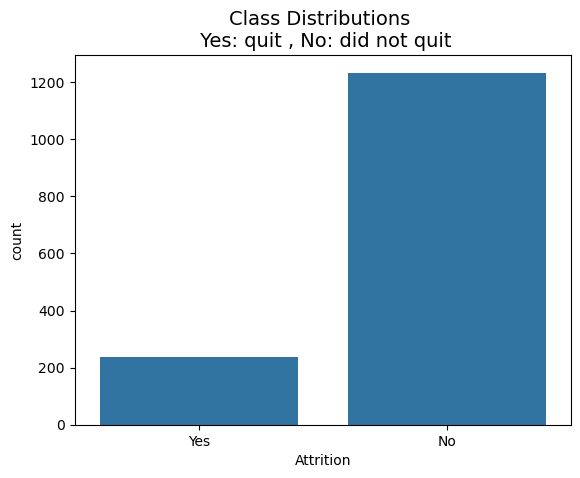

In [8]:
sns.countplot(x ='Attrition', data=df)
plt.title('Class Distributions \n Yes: quit , No: did not quit', fontsize=14)
              

In [9]:
rate = df['DailyRate'].values
age_ = df['Age'].values

<Axes: >

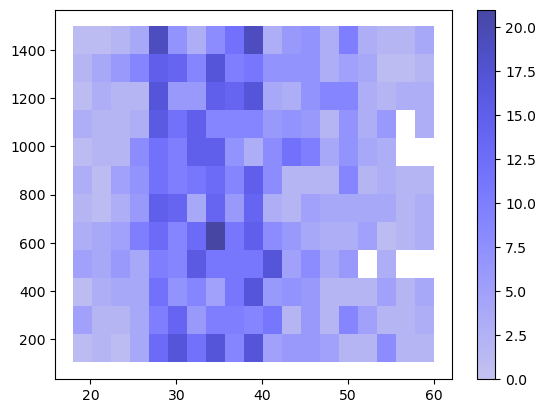

In [10]:
#зависимость возраста от з/п в день
sns.histplot(x = age_, y = rate,  color='b', cbar=True)


In [11]:
df.select_dtypes(include='object').head(1)

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes


In [12]:
df.head(1)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5


In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
#переведу категориальные признаки в числовые
df['Attrition'].replace(['No', 'Yes'],
                        [0, 1], inplace=True)

In [15]:
df['BusinessTravel'].replace(['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],
                             [1, 2, 3], inplace=True)

In [16]:
#попробую разбить сферы занятости на численные значения
df_dum = df.copy()
df_dum = pd.get_dummies(df_dum, columns = ['EducationField', 'Department', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime' ], dtype = int)

In [17]:
df_dum['EmployeeCount'].value_counts()

EmployeeCount
1    1470
Name: count, dtype: int64

Дропу бесполезные фичи

In [19]:
df_dum = df_dum.drop('EmployeeCount', axis=1)

In [20]:
df_dum = df_dum.drop('Over18', axis=1)

In [21]:
df_dum = df_dum.drop('StandardHours', axis=1)

In [22]:
df_dum.head(3)

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1,2,1102,1,2,1,2,94,3,...,0,0,0,1,0,0,0,1,0,1
1,49,0,3,279,8,1,2,3,61,2,...,0,0,1,0,0,0,1,0,1,0
2,37,1,2,1373,2,2,4,4,92,2,...,0,0,0,0,0,0,0,1,0,1


In [23]:
df['BusinessTravel'].value_counts()

BusinessTravel
2    1043
3     277
1     150
Name: count, dtype: int64

In [24]:
df['EducationField'].value_counts()

EducationField
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: count, dtype: int64

In [25]:
print('still working', round(df_dum['Attrition'].value_counts()[0]/len(df_dum) * 100,2), '% of the dataset')
print('quited', round(df_dum['Attrition'].value_counts()[1]/len(df_dum) * 100,2), '% of the dataset')

still working 83.88 % of the dataset
quited 16.12 % of the dataset


Соберу первоначальный пайплайн, а после перейду к настройке модели

In [27]:
X = df_dum.drop('Attrition', axis =1)
y = df_dum['Attrition']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
scaler = RobustScaler()

In [30]:
models ={'logistic_regression': LogisticRegression(max_iter=1000),
         'gradient_boost': GradientBoostingClassifier(),
        'RandomForest': RandomForestClassifier(n_jobs=1, random_state=42)
        }


In [31]:
for name, model in models.items():
    clf = pipeline.make_pipeline(scaler, model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1] # возвращает вероятность класса 1
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_prob)
    pr_score = average_precision_score(y_test, y_prob)
    print(f'{name}: accuracy = {accuracy:.2f}, f1 = {f1:.2f}, roc_auc = {roc_auc:.2f}, pr_score = {pr_score:.2f}')    

logistic_regression: accuracy = 0.86, f1 = 0.44, roc_auc = 0.81, pr_score = 0.58
gradient_boost: accuracy = 0.85, f1 = 0.31, roc_auc = 0.79, pr_score = 0.47
RandomForest: accuracy = 0.85, f1 = 0.18, roc_auc = 0.78, pr_score = 0.44


accuracy  для несбалансированных данных - плохой показатель. f1 небольшой, что понятно( данные несбалансированы). roc_auc довольной высокий, модель отличает классы.

Научу модель на одинаковых разбиенях. Посмотрю насколько она стабильна при разных условиях

In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
for name, model in models.items():
    clf = pipeline.make_pipeline(scaler, model)
    
    roc_score = cross_val_score(clf, X_train, y_train, cv=skf, scoring='roc_auc')
    pr_score = cross_val_score(clf, X_train, y_train, cv=skf, scoring='average_precision')
    print(f'{name}: ROC_AUC = {roc_score.mean():.2f} ± {roc_score.std():.2f}; PR = {pr_score.mean():.2f} ± {pr_score.std():.2f}')

    print('ROC_AUC по фолдам:',[f"{s:.2f}" for s in roc_score])
    print('PR_AUC  по фолдам:', [f"{s:.2f}" for s in pr_score])

logistic_regression: ROC_AUC = 0.84 ± 0.03; PR = 0.65 ± 0.06
ROC_AUC по фолдам: ['0.82', '0.82', '0.86', '0.89', '0.81']
PR_AUC  по фолдам: ['0.67', '0.54', '0.68', '0.73', '0.65']
gradient_boost: ROC_AUC = 0.81 ± 0.02; PR = 0.59 ± 0.04
ROC_AUC по фолдам: ['0.78', '0.80', '0.83', '0.83', '0.81']
PR_AUC  по фолдам: ['0.56', '0.52', '0.64', '0.63', '0.60']
RandomForest: ROC_AUC = 0.79 ± 0.04; PR = 0.54 ± 0.06
ROC_AUC по фолдам: ['0.76', '0.74', '0.82', '0.84', '0.80']
PR_AUC  по фолдам: ['0.53', '0.42', '0.61', '0.57', '0.55']


после разбиения на фолды результат стал заметно лучше, хотя и присутствует нестабильность для разных фолдов
1) У лог регрессии разброс ROC_AUC небольшой 0.81-0.89 - метрика достаточно стабильна, а  у PR_AUC разброс больше 0.54–0.73, это вполне ожидаемо т.к метрика чувствительна к редкому классу
2) у градиентного бустинга самые стабильные результаты для обеих метрик

In [37]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Далее продолжу использовать 2 модели: лог. регрессию и бустинг, как самые стабильные. Хочу перебрать параметры и обучить модель на лучших, а также добавлю SMOTE, чтобы убрать дисбаланс классов

In [39]:
params_lr = {
    "logisticregression__C": [0.05, 0.1, 1, 5, 10, 15],
    "logisticregression__solver": ['liblinear', 'saga'],
    "logisticregression__penalty": ['l1', "l2"]}


In [40]:
params_gb = {
    "GradientBoost__n_estimators": [100, 200],
    "GradientBoost__learning_rate": [0.05, 0.1],
    "GradientBoost__max_depth": [3, 5],
    "GradientBoost__subsample": [0.8, 1.0],
    "GradientBoost__min_samples_split": [2, 5],
    "GradientBoost__min_samples_leaf": [1, 3]
}

In [41]:
pipe_lr = ImbPipeline(steps=[
    ("scaler", RobustScaler()),
    ("smote", SMOTE(random_state=42)),
    ("logisticregression", LogisticRegression(max_iter=1000, random_state=42))
])

In [42]:
pipe_gb = ImbPipeline(steps=[
    ("scaler", RobustScaler()),
    ("smote", SMOTE(random_state=42)),
    ("GradientBoost", GradientBoostingClassifier())
])

In [43]:
rs_search_lr = RandomizedSearchCV(estimator=pipe_lr, param_distributions=params_lr, cv=skf, n_jobs=-1, scoring={"roc_auc": "roc_auc", "pr_auc": "average_precision"},refit="pr_auc", random_state=42)

In [44]:
rs_search_gb = RandomizedSearchCV(estimator=pipe_gb, param_distributions=params_gb, cv=skf, n_jobs=-1,n_iter=10, scoring={"roc_auc": "roc_auc", "pr_auc": "average_precision"},refit="pr_auc", random_state=42)

In [45]:
rs_search_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.05, 0.1, 1,
                                                                  5, 10, 15],
                                        'logisticregression__penalty': ['l1',
                                                                        'l2'],
                                        'logisticregression__solver': ['liblinear',
                                                                       'saga']},
                   random_state=42, refit='pr_auc',
                   scoring={'pr_auc': 'average_precision',
                            'roc_auc': 'roc_auc'})

In [46]:
rs_search_gb.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('GradientBoost',
                                              GradientBoostingClassifier())]),
                   n_jobs=-1,
                   param_distributions={'GradientBoost__learning_rate': [0.05,
                                                                         0.1],
                                        'GradientBoost__max_depth': [3, 5],
                                        'GradientBoost__min_samples_leaf': [1,
                                                                            3],
                                        'GradientBoost__min_samples_split': [2,
                                                                             5],
                                        'GradientBoost__n_estimators': [100,
                                                                        200],
                                        'GradientBoost__subsample': [0.8, 1.0]},
                   random_state=42, refit='pr_auc',
                   scoring={'pr_auc': 'average_precision',
                            'roc_auc': 'roc_auc'})

Оценим модели и сравним метрики


In [48]:
best_lr = rs_search_lr.best_estimator_
best_gb = rs_search_gb.best_estimator_

In [49]:
for name, model in [('best log_regression',best_lr), ('best gradient_boost',best_gb)]:
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # предсказываем класс 1
    print(f"\n{name} на тесте:")
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("PR SCORE:", average_precision_score(y_test, y_prob))
    print(classification_report(y_test, y_pred, digits=4))


best log_regression на тесте:
Precision: 0.42105263157894735
Recall: 0.6808510638297872
F1: 0.5203252032520326
ROC AUC: 0.8036006546644845
PR SCORE: 0.5922026175834336
              precision    recall  f1-score   support

           0     0.9312    0.8219    0.8731       247
           1     0.4211    0.6809    0.5203        47

    accuracy                         0.7993       294
   macro avg     0.6761    0.7514    0.6967       294
weighted avg     0.8496    0.7993    0.8167       294


best gradient_boost на тесте:
Precision: 0.631578947368421
Recall: 0.2553191489361702
F1: 0.36363636363636365
ROC AUC: 0.7771556550951847
PR SCORE: 0.5123137574834653
              precision    recall  f1-score   support

           0     0.8727    0.9717    0.9195       247
           1     0.6316    0.2553    0.3636        47

    accuracy                         0.8571       294
   macro avg     0.7522    0.6135    0.6416       294
weighted avg     0.8342    0.8571    0.8307       294



Logistic Regression выдает много ложноположительных, но зато относительно неплохой recall. ROC AUC довольно высокий, в целом модель неплохо отличает классы.
Думаю можно сделать вывод, что логистическая регрессия больше ориентирована для нахождения миноритарного класса.
А вот gradient_boost как будто бы "осторожнее", неплохая точность, но пропускает много обьектов класса 1.
PR AUC показывает, что Logistic Regression чуть лучше по работе с редким классом, хотя и модель проще

А ещё важно отметить рост метрик после применения smote и randomsearch, особенно f1. То есть можно утверждать, что улучшилась способность модели находить редкие положительные события
logistic_regression:  f1 = 0.44 -> 0.52, roc_auc = 0.81 -> 0.81, pr_score = 0.58 -> 0.59

Для улучшения работы модели, мне кажется, стоит поработать с порогом(treshold), можно еще заняться предобработкой, создать новые более информативные фичи


Далее построю корреляционные матрицы, найду наиболее значимые фичи, проинтерпретирую результаты

Text(0.5, 1.0, "Imbalanced Correlation Matrix \n (don't use for reference)")

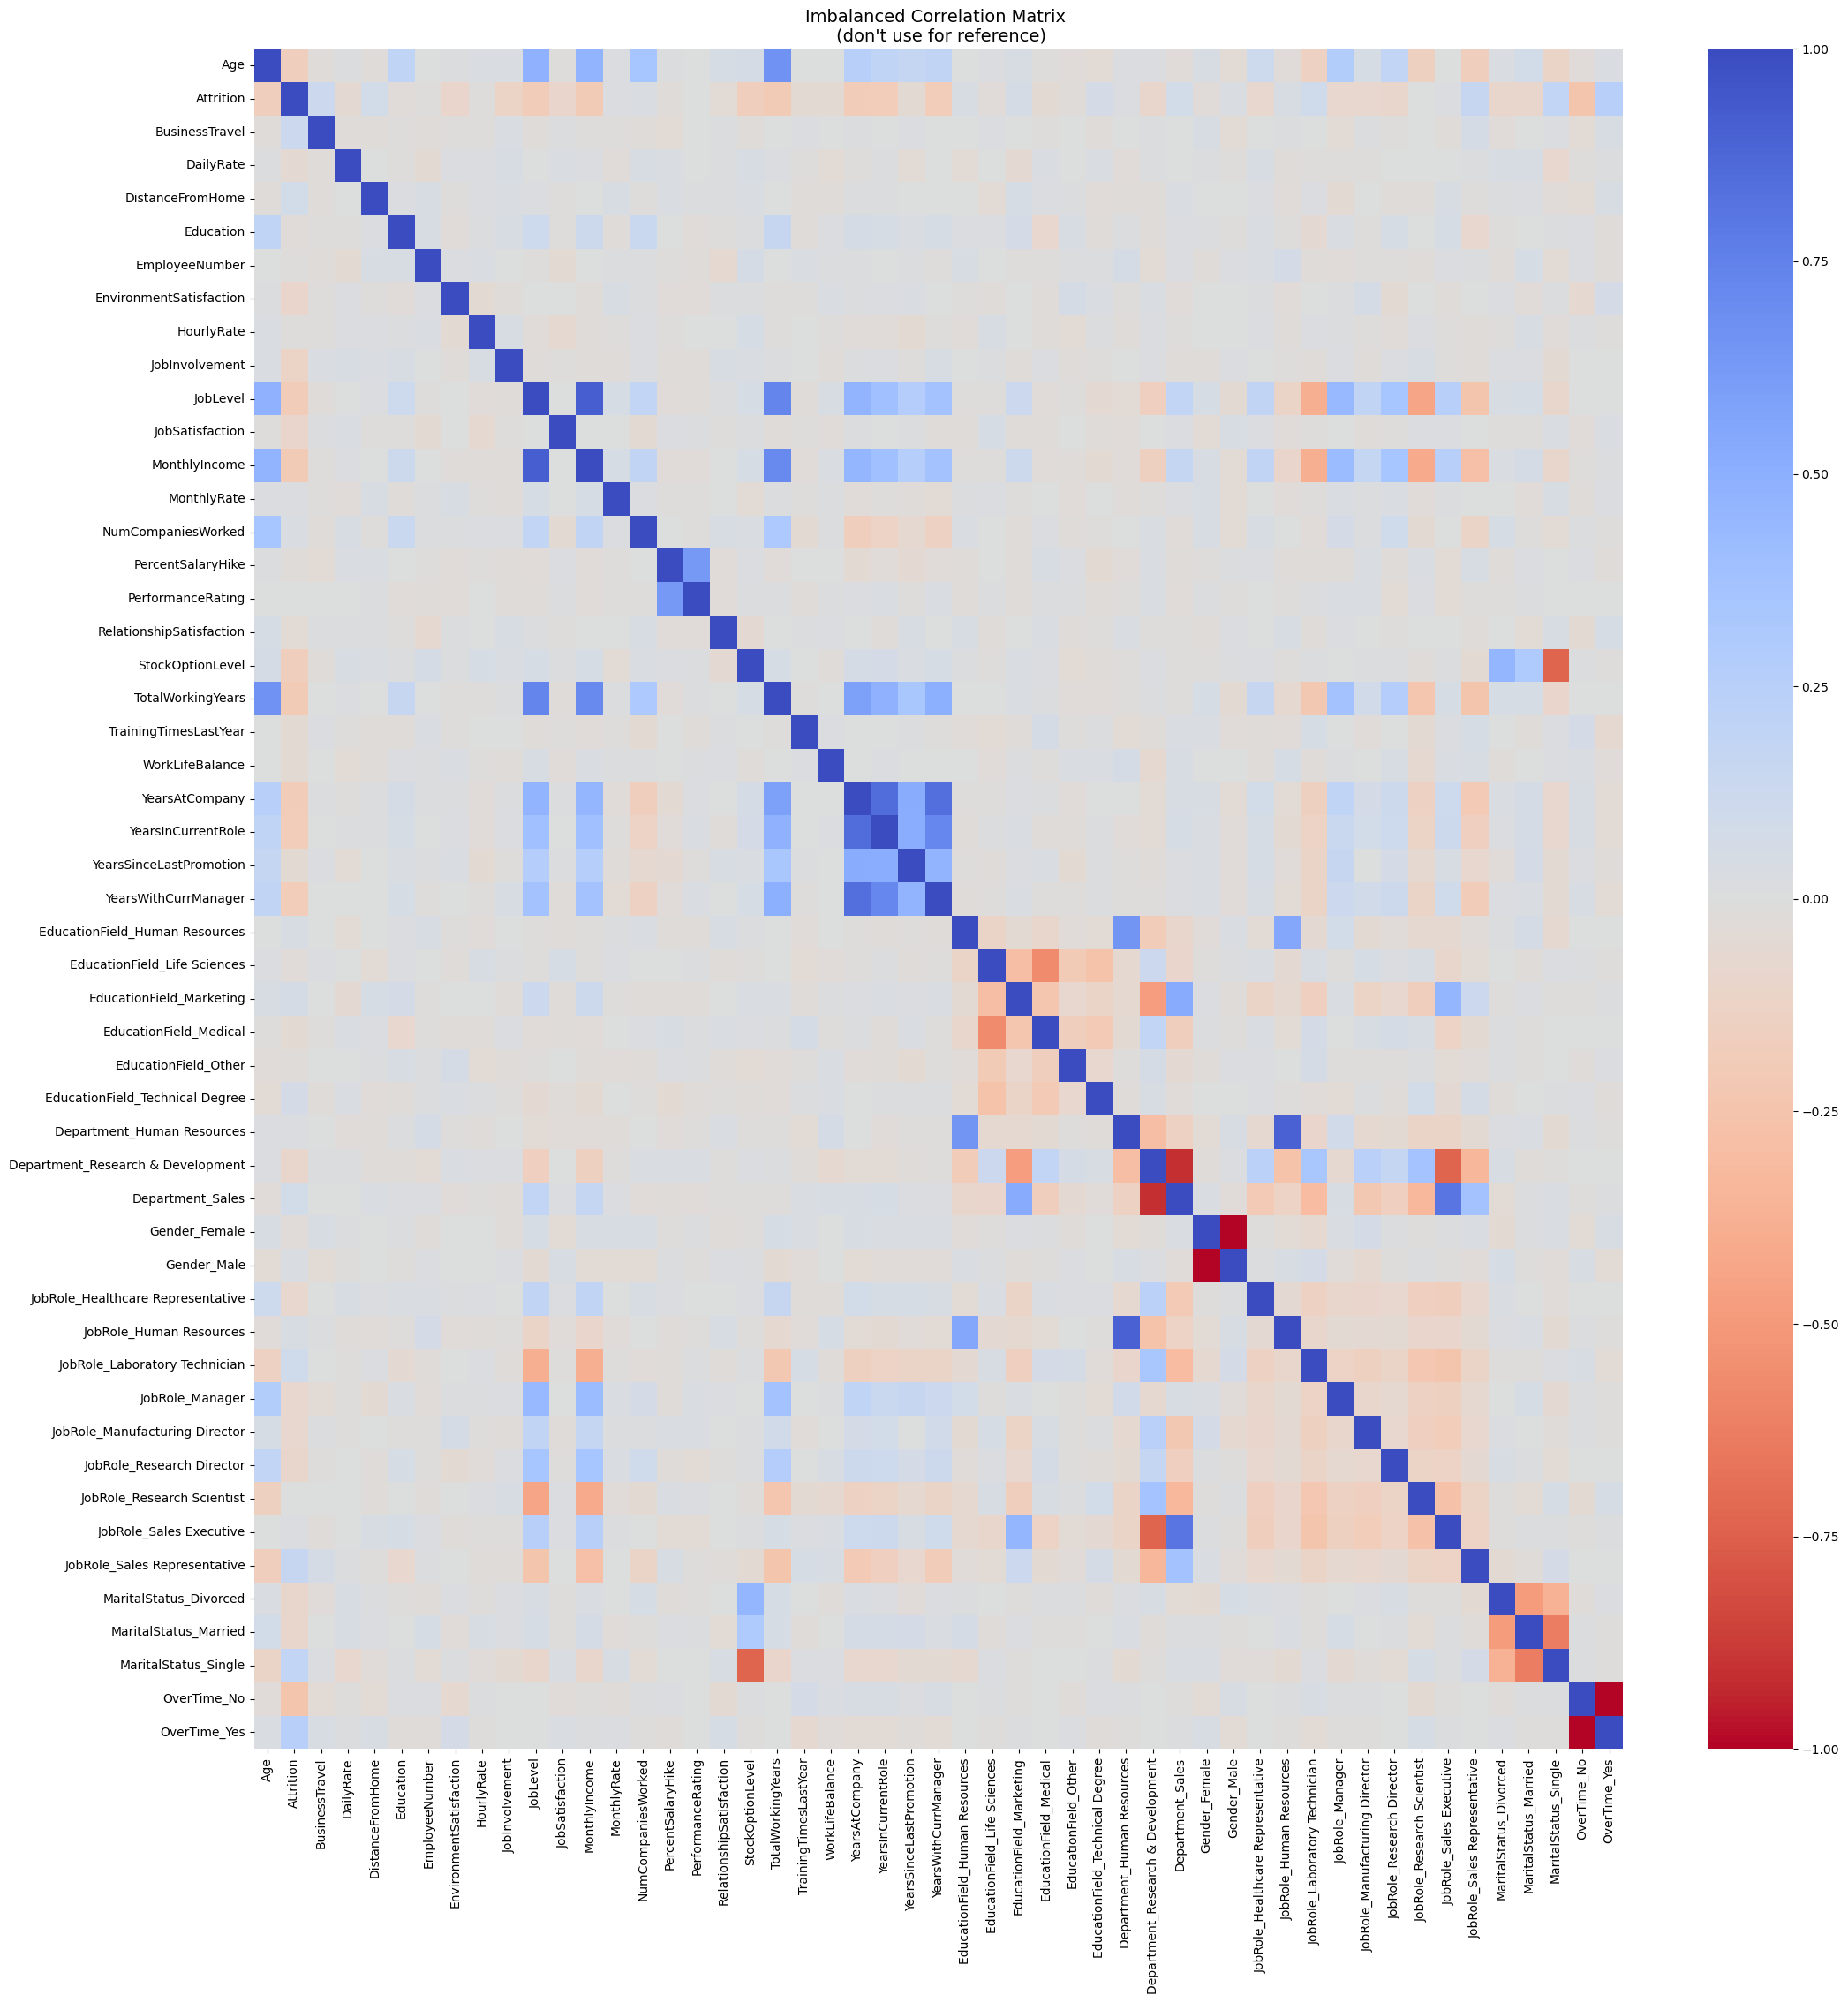

In [54]:
f, ax1 = plt.subplots(1, 1, figsize=(25,25))
my_matrix = df_dum.corr(method='spearman').round(2) 
sns.heatmap(my_matrix, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

In [55]:
best_model = rs_search_gb.best_estimator_

In [56]:
gb_clf = best_model.named_steps['GradientBoost']

In [57]:
feature_importances = gb_clf.feature_importances_

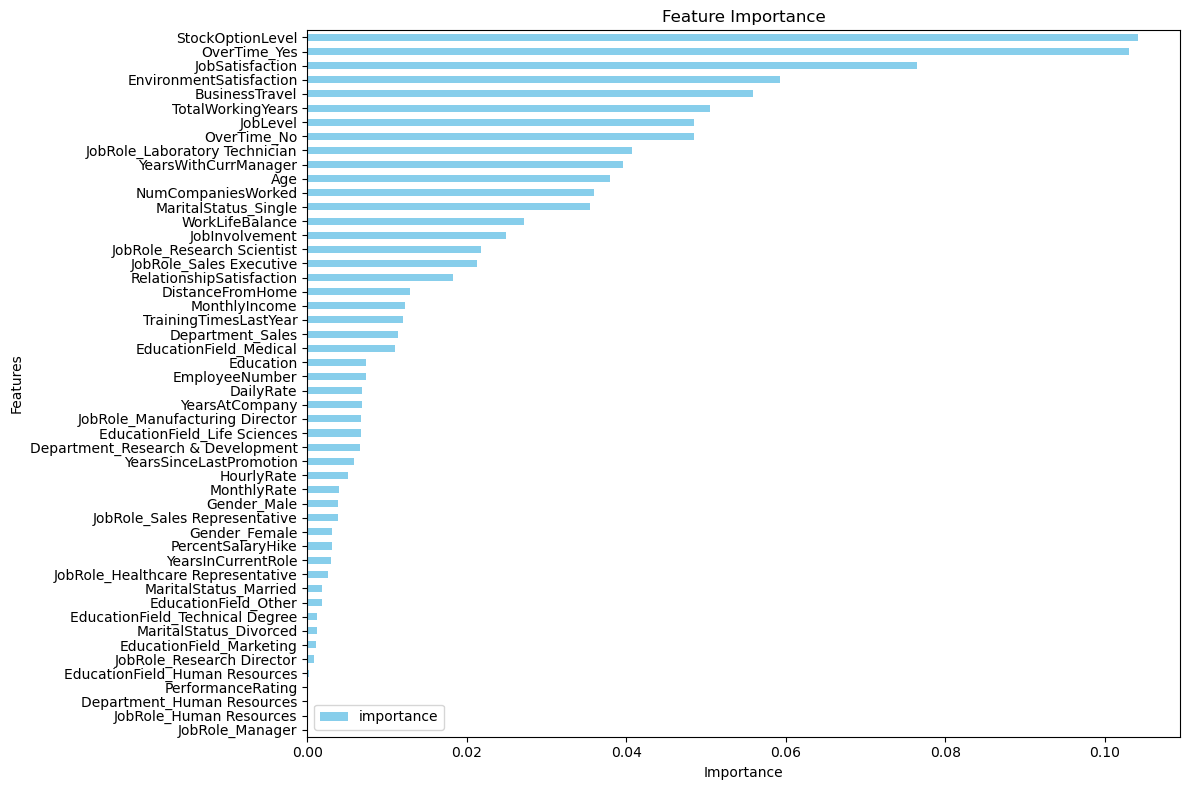

In [58]:
imp = pd.DataFrame(feature_importances, index=X.columns, columns=['importance'])
imp.sort_values('importance', ascending=True).plot(
    kind='barh',
    figsize=(12, 8),
    color='skyblue'
)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Видим довольно интересную картину, на предсказание, что человек уволится, сильнее всего влияет возможность овертаймить. Далее уже идут более предсказуемые фичи, которые компания могла бы при желании исправить, если бы захотела удержать сотрудников